# Assignment 4

**Deadline**: February 17, 9pm

**Late Penalty**: See Syllabus

**TA**: Hojjat Salehinejad

In this assignment, you will build and train an autoencoder for imputation of missing data. In the process, you will:

1. Clean and process continuous and categorical data for machine learning.
2. Understand and implement denoising autoencoders.
3. Tuning the hyperparameter setting of an autoencoder.

### What to submit

Submit a PDF file containing all your code and outputs. Do not submit any other files produced by your code.

Completing this assignment using Jupyter Notebook is recommended (though not necessarily for all subsequent assignments). If you are using Jupyter Notebook, you can export a PDF file using the menu option File -> Download As -> PDF via LaTeX (pdf)

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 
Installation instructions for `pandas` is available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

If you cannot get `pandas` installed, you may port the `pandas` code
we provided into `numpy` code.

In [2]:
import pandas as pd

# Part 1. Data Cleaning [12 pt]

The data set we will be using for this assignment is the 
Adult Data Set provided by UCI Machine Learning Repository [1] available 
at https://archive.ics.uci.edu/ml/datasets/adult.

Download the file `adult.data` from the website.

The data set contains census record files of adults, including their
age, type of work they do, martial status, etc. We will build a denoising
autoencoder on this dataset to impute (or "fill in") missing values
in the dataset.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### Part (a) Loading the Data [1 pt]

Use the function `pd.read_csv` to load the `adult.data` into a pandas
dataframe called `df`. Make sure that
the `adult.data` file is in the same folder as your notebook or python code.
Report the number of rows (records) in your data frame.

Note that the data file does **not** have an index column. The headers
of the file are given to you below. 

Hint: You will need to read a bit about the pandas documentation 
to do this problem https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country','salary']
df = pd.read_csv('adult.data',header=None,names=header)
number_rows = len(df.index)
print(number_rows)

32561


### Part (b) Continuous Features [1 pt]

For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], find the minimum, maximum, and average value across the dataset.

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 5 rows of the data frame (5 records) below:

In [4]:
df[:3]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [5]:
newSet = pd.DataFrame(df, columns=['age','yredu','capgain', 'caploss','workhr'])
newSet.min()

age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64

In [6]:
newSet.max()

age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64

In [7]:
newSet.mean()

age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64

In [8]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [9]:
np.sum(subdf["caploss"])

2842700

### Part (c) Normalizing Continuous Features [1 pt]

Normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"]
so that their values are between 0 and 1. Just like numpy arrays, you can modify
data frames. For example, the code 

`df["age"] = df["age"] + 1` 

would increase everyone's age by 1.

In [10]:
df["age"] = (df["age"]-df["age"].min())/(df["age"].max()-df["age"].min())
df["yredu"] = (df["yredu"]-df["yredu"].min())/(df["yredu"].max()-df["yredu"].min())
df["capgain"] = (df["capgain"]-df["capgain"].min())/(df["capgain"].max()-df["capgain"].min())
df["caploss"] = (df["caploss"]-df["caploss"].min())/(df["caploss"].max()-df["caploss"].min())
df["workhr"] = (df["workhr"]-df["workhr"].min())/(df["workhr"].max()-df["workhr"].min())
df[:3]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country,salary
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States,<=50K
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States,<=50K


### Part (d) Categorical Features [1 pt]

What percentage of people in our data set is male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set is female?

In [11]:
# hint: you can do something like this in pandas
MalePercent = sum(df["sex"] == " Male")/(len(df.index))
MalePercent

0.6692054912318418

### Part (e) Missing Values [1 pt]

We will do two things in this part:

1. We will restrict ourselves to a subset of the features
2. We will remove any records (rows) containing missing values, and store it in a second dataframe.

Both of these steps are done for you.

Report the number of records with and without missing features of interest.

In [12]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [13]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [14]:
len(df_with_missing.index)

1843

In [15]:
len(df_not_missing.index)

30718

### Part (f) One-Hot Encoding [1 pt]

What are all the possible values of "work" in `df_not_missing`? You may find the Python function `set` useful.

In [16]:
not_missing_set = set(df_not_missing["work"])
not_missing_set

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

As discussed in class and in tutorial, we will be using a one-hot encoding 
to encode each of the categorical variables.

We will use the pandas function `get_dummies`:

In [17]:
data = pd.get_dummies(df_not_missing)

In [18]:
data[:5]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


### Part (g) One-Hot Encoding [1 pt]

How many columns are in the dataframe `data`?

Briefly explain where that number come from. (You don't need to be detailed here.)

    57 columns are in the dataframe. These data frame are all the possible values for each of the columns in dataframe.

### Part (h) One-Hot Conversion [3 pt]

We will convert the pandas data frame into numpy below.
However, in doing so, we lose the column information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will use this function on the output of our autoencoder,
to interpret our autoencoder outputs. So the input 
one-hot vectors might not actually be "one-hot".


In [19]:
datanp = data.values.astype(np.float32)

In [20]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of feature. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # TODO
    max_index = np.argmax(onehot)
    
    new_list = cat_values[feature]
    return new_list[max_index]

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [21]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

### Part (i) Train/Test Split [2 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [22]:
np.random.seed(50) # set the numpy seed for consistent split

# todo
np.random.seed(50) # set the numpy seed for consistent split
np.random.shuffle(datanp)
train_index = int(len(datanp)*0.7)
vali_index =  int(len(datanp)*0.85)

train_data = datanp[:train_index]
valid_data = datanp[train_index:vali_index]
test_data = datanp[vali_index:]
# todo

## Part 2. Model Setup [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`. 

There will be a sigmoid activation at the decoder, so that
the output of the decoder is between 0 and 1. We will not interpret 
the output of the sigmoid as a probability.

In [23]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name="AutoEncode"
        self.encoder = nn.Sequential(
            nn.Linear(57, 43), # TODO
            nn.Linear(43,28)
        )
        self.decoder = nn.Sequential(
            nn.Linear(28,43),
            nn.Linear(43, 57), # TODO
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder as follows:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, obtaining a reconstruction
- We will check how close the reconstruction is compared to the original data (without the missing feature)

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyways.)

In [24]:
from a4code import get_model_name,plot_training_curve
import time



def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    #optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for data in loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = net(datam)
        loss = criterion(recon, data)
        loss.backward()
       
            
        total_loss+=loss.item()
    loss = float(total_loss) / (i + 1)

    return loss

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_data_loader(batch_size):
    train_loader =  torch.utils.data.DataLoader(train_data,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)
    val_loader = torch.utils.data.DataLoader(valid_data,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)
    return train_loader,test_loader,val_loader

def train(model, train_loader, valid_loader,batch_size=64,num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    start_time = time.time()
    
    for epoch in range(num_epochs):
        total_train_error =0.0
        total_train_loss = 0.0
        i = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
            total_train_loss+=loss.item()
            i+=1
        
        train_acc[epoch]=get_accuracy(model, train_loader)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch]=get_accuracy(model, valid_loader)
        val_loss[epoch]=evaluate(model, valid_loader,criterion)
        
        
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs)
        torch.save(model.state_dict(), model_path)
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)

    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
        

       
        
        

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are less easy to compare
than accuracy percentages. The reason is that the scale of the loss value changes depending
on your batch size. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. You don't need to do anything else in this part. To earn the 4 marks,
plot the training and validation accuracy every few iterations/epochs as part of your
training curve.

In [25]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set
    
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             depending on your variable naming this code might not work
             out of the box)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run the training code, using reasonable settings like batch_size, learning rate, etc.

Include your training curve in your pdf output.

In [26]:
train_loader, test_loader, vali_loader = get_data_loader(batch_size=64)

In [27]:
net1 = AutoEncoder()
train(net1,train_loader,vali_loader, num_epochs=30)

Epoch 1: Train acc: 0.44382693082814, Train loss: 0.1586811936706393 |Validation acc: 0.4424913194444444, Validation loss: 0.09604908382160622
Epoch 2: Train acc: 0.4663209623910954, Train loss: 0.07162785585361701 |Validation acc: 0.46556712962962965, Validation loss: 0.08890925347805023
Epoch 3: Train acc: 0.47211112144606704, Train loss: 0.06904286065467741 |Validation acc: 0.4718967013888889, Validation loss: 0.08634169804945327
Epoch 4: Train acc: 0.4819009084426255, Train loss: 0.0665548256534851 |Validation acc: 0.4793836805555556, Validation loss: 0.08217371398942512
Epoch 5: Train acc: 0.5227188168542461, Train loss: 0.06269235457970763 |Validation acc: 0.5220269097222222, Validation loss: 0.07713727999413222
Epoch 6: Train acc: 0.5246798747403343, Train loss: 0.05896366992274449 |Validation acc: 0.5235460069444444, Validation loss: 0.07277526294714526
Epoch 7: Train acc: 0.5264471522028958, Train loss: 0.056294260651580656 |Validation acc: 0.5248119212962963, Validation loss:

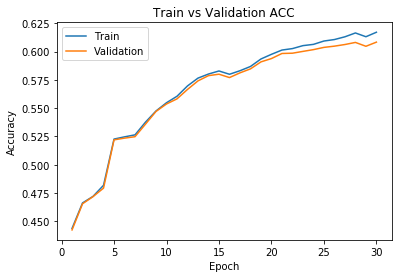

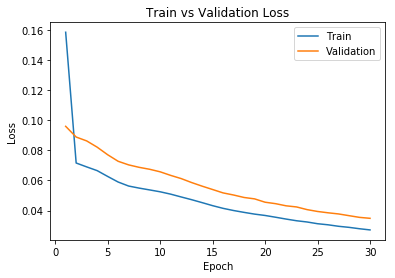

In [30]:
plot_training_curve(get_model_name(net1.name,batch_size=64,learning_rate=0.0001, epoch=30))

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models.

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

### Explaination for Net2

From net1, I realized that the learning rate I am using is not high enough as the model is being trained, the validation accuracy stay roughly the same. Therefore, I have decided to increase the learning rate by a magnitude of 10. 

In [31]:
net2 = AutoEncoder()
train(net2,train_loader,vali_loader, num_epochs=30, learning_rate=0.001)

Epoch 1: Train acc: 0.5818838557653552, Train loss: 0.07098981226277634 |Validation acc: 0.5811631944444444, Validation loss: 0.0531075610534141
Epoch 2: Train acc: 0.6054475552661768, Train loss: 0.03482385515857167 |Validation acc: 0.6019241898148148, Validation loss: 0.03907299992677413
Epoch 3: Train acc: 0.6193842433262022, Train loss: 0.027407474954023913 |Validation acc: 0.6151620370370371, Validation loss: 0.031523821875452995
Epoch 4: Train acc: 0.6234226273524943, Train loss: 0.02249214804568259 |Validation acc: 0.6202980324074074, Validation loss: 0.026593089904309364
Epoch 5: Train acc: 0.6238877003689579, Train loss: 0.020117446003642032 |Validation acc: 0.6197916666666666, Validation loss: 0.024847939888244134
Epoch 6: Train acc: 0.627011440796205, Train loss: 0.017934213917514513 |Validation acc: 0.6242042824074074, Validation loss: 0.022233658682620318
Epoch 7: Train acc: 0.630894800483676, Train loss: 0.016661745717179703 |Validation acc: 0.6287615740740741, Validation

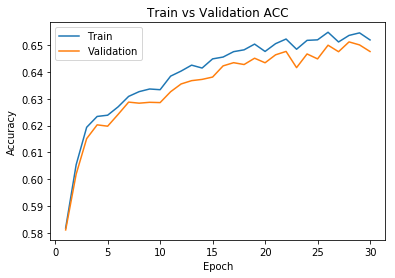

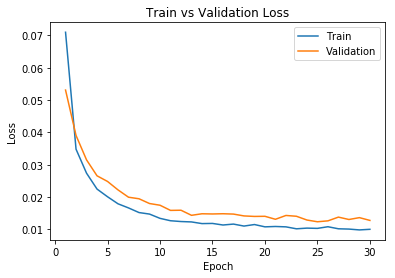

In [32]:
plot_training_curve(get_model_name(net2.name,batch_size=64,learning_rate=0.001, epoch=30))

### Explaination for Net3

As I have observed from Net2, having a high learning rate did not make the validation performance increase by much. Therefore, I decide to make some adjustment of the batch size of the model. 

In [33]:
train_loader, test_loader, vali_loader = get_data_loader(batch_size=128)
net3 = AutoEncoder()
train(net3,train_loader,vali_loader, num_epochs=30, learning_rate=0.0006, batch_size=128)

Epoch 1: Train acc: 0.4710026974234955, Train loss: 0.10551973053160504 |Validation acc: 0.4693287037037037, Validation loss: 0.04327415897135149
Epoch 2: Train acc: 0.5306793166527145, Train loss: 0.061089539713055425 |Validation acc: 0.5309606481481481, Validation loss: 0.03449017698304695
Epoch 3: Train acc: 0.567985923790035, Train loss: 0.05042004693277489 |Validation acc: 0.5656467013888888, Validation loss: 0.028988673825535858
Epoch 4: Train acc: 0.5826512262425201, Train loss: 0.041224390047894424 |Validation acc: 0.5807291666666666, Validation loss: 0.024839175244172413
Epoch 5: Train acc: 0.5896195702725328, Train loss: 0.03682147654203268 |Validation acc: 0.5881076388888888, Validation loss: 0.022799982640304063
Epoch 6: Train acc: 0.6084395250054259, Train loss: 0.03404002652101263 |Validation acc: 0.6046730324074074, Validation loss: 0.020629264937158217
Epoch 7: Train acc: 0.6150280594053267, Train loss: 0.031024570439076988 |Validation acc: 0.6101707175925926, Validatio

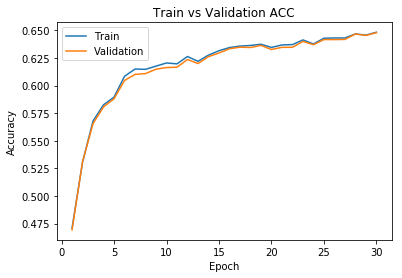

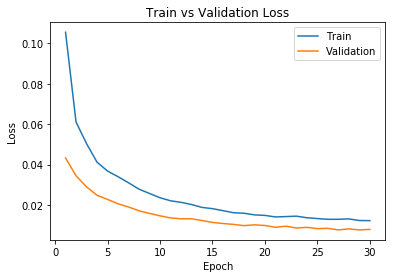

In [34]:
plot_training_curve(get_model_name(net3.name,batch_size=128,learning_rate=0.0006, epoch=30))

### Explaination for Net4

As I have observed from Net3, having a high batch size did not make the validation performance increase by much from Net2. Therefore, I decide to increase both the batch size and the learning rate. However, this action may result in over-fitting and increases in noise for the model. I am planning to overfit the mode first and then find out new parameters based on the data given. In addition, I also increase the numuber of epoches to 50. I am hoping that this would also help to increase the validation to be greater than 65%.

In [35]:
net4 = AutoEncoder()
train(net4,train_loader,vali_loader, num_epochs=50, learning_rate=0.001, batch_size=128)

Epoch 1: Train acc: 0.5133786004402692, Train loss: 0.09030418023026202 |Validation acc: 0.5120804398148148, Validation loss: 0.03556143681992564
Epoch 2: Train acc: 0.5757448919480358, Train loss: 0.05029133544165707 |Validation acc: 0.5739655671296297, Validation loss: 0.02768354281260256
Epoch 3: Train acc: 0.5884413852974917, Train loss: 0.03861296615568844 |Validation acc: 0.5868778935185185, Validation loss: 0.022746017954328603
Epoch 4: Train acc: 0.6129584844820637, Train loss: 0.03419670834035211 |Validation acc: 0.6094111689814815, Validation loss: 0.02023227323304143
Epoch 5: Train acc: 0.617151892847177, Train loss: 0.029196264299415273 |Validation acc: 0.6121238425925926, Validation loss: 0.017492544036685376
Epoch 6: Train acc: 0.6171828977149413, Train loss: 0.02556832662656815 |Validation acc: 0.61328125, Validation loss: 0.015225274226906007
Epoch 7: Train acc: 0.6159427030043717, Train loss: 0.02203079929145483 |Validation acc: 0.6133174189814815, Validation loss: 0.0

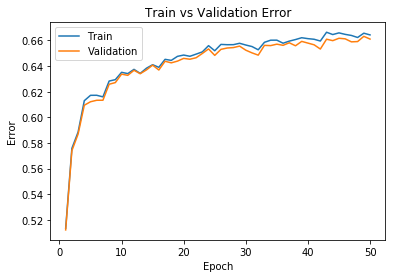

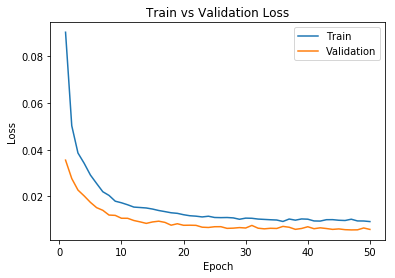

In [36]:
from a4code import plot_training_curve50
plot_training_curve50(get_model_name(net4.name,batch_size=128,learning_rate=0.001, epoch=50))

### Explaination for Net4

As I have observed from Net4, having a high batch size increased the validation performance by a little bit. It did introduce more noise towards the end of the training process. Therefore, I decide to decrease the batch size and increase the learning rate. However, this action may cause more errors due to too much leap while training the network. Running the model for 50 epoch seems to have acchieved some outcome. But this might be a result of overfitting. However, we will remain it at 50 epoch.

In [37]:
train_loader, test_loader, vali_loader = get_data_loader(batch_size=64)

net5 = AutoEncoder()
train(net5,train_loader,vali_loader, num_epochs=50, learning_rate=0.003, batch_size=64)

Epoch 1: Train acc: 0.608191486063312, Train loss: 0.04932020922420817 |Validation acc: 0.6054325810185185, Validation loss: 0.03391919664123602
Epoch 2: Train acc: 0.6153536105168511, Train loss: 0.02169934006336004 |Validation acc: 0.6094473379629629, Validation loss: 0.021996697214873212
Epoch 3: Train acc: 0.6225854959228599, Train loss: 0.017193438667660297 |Validation acc: 0.6199725115740741, Validation loss: 0.020789152558631542
Epoch 4: Train acc: 0.6323442780516542, Train loss: 0.015268954115391926 |Validation acc: 0.6300636574074074, Validation loss: 0.01702125262665121
Epoch 5: Train acc: 0.6380724273710973, Train loss: 0.014185706322089677 |Validation acc: 0.6346932870370371, Validation loss: 0.01746656270207543
Epoch 6: Train acc: 0.6401730071621244, Train loss: 0.013321702756838824 |Validation acc: 0.6370442708333334, Validation loss: 0.01594954263418913
Epoch 7: Train acc: 0.6427774160543205, Train loss: 0.012383221166390781 |Validation acc: 0.6397569444444444, Validatio

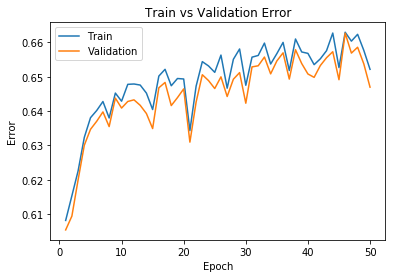

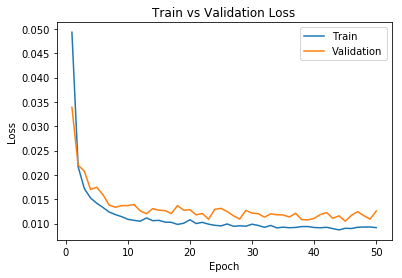

In [39]:
plot_training_curve50(get_model_name(net5.name,batch_size=64,learning_rate=0.003, epoch=50))

### Conclusion on Hyperparameters

    Base on the results from the graph, the decrease in batch size with increased learning rate have introduced more noise. Therefore the net4 will be the best model to be used to test for the test set. 

## Part 4. Testing [6 pt]

### Part (a) [1 pt]

Compute the test accuracy across the test set.

In [45]:
test_acc = get_accuracy(net4, test_loader)
test_acc

0.6617115162037037

### Part (b) [2 pt]

Consider an alterative, baseline model that predicts missing data as follows. To predict a missing feature, the
baseline model will look at the **most common value** of the feature in the training set. For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set.

What would be the test accuracy of this baseline model?

It is often helpful to use the performance of the baseline model to help judge how well our model is actually performing. No explanation is required in this question, just your calculations.

In [ ]:
# find the most commond entry for all columns 



### Part (c) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [47]:
first_row = test_data[0]
features = get_features(first_row)
print("Education Level: ",get_feature(first_row, "edu"))
print("All feature: ", features)

Education Level:  Bachelors
All feature:  {'work': 'Private', 'marriage': 'Divorced', 'occupation': 'Prof-specialty', 'edu': 'Bachelors', 'relationship': 'Not-in-family', 'sex': 'Male'}


    People could judge others' education based on other features. However, this is not 100% relatable as not all the feature would make sense to play a role in the education level of an individual. Therefore, I do not beleive it's reasonable to judge base on those features. 

### Part (d) [2 pt]

What is your model's guess of this person's education
level, given their other features?


In [77]:
for item in test_loader:
    out = net4(zero_out_feature(item.clone(), "edu")).detach().numpy()
    break

print(get_feature(out[0],"edu"))


Bachelors
